# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

### Загрузка и изучение данных

Импорт библиотек `pandas` и `matplotlib`, а также необходимых функций из библиотеки `sklearn`:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import spacy
import nltk
from sklearn.pipeline import Pipeline
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

Отключим вывод предупреждений.

In [2]:
import warnings
warnings.filterwarnings('ignore')

Чтение csv-файла и вывод первых 10 строк.

In [3]:
df = pd.read_csv('/datasets/toxic_comments.csv')
df.head(10)

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0
5,5,"""\n\nCongratulations from me as well, use the ...",0
6,6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,7,Your vandalism to the Matt Shirvington article...,0
8,8,Sorry if the word 'nonsense' was offensive to ...,0
9,9,alignment on this subject and which are contra...,0


Вывод информации о таблице методом `info()`.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


Удалим лишний столбец `Unnamed: 0`.

In [5]:
df = df.drop('Unnamed: 0', axis=1)

### Очистка и лемматизация текста

Напишем функцию `clear_text()` для очистки текста. С помощью регулярного выражения оставим только буквы английского алфавита и пробелы.

In [6]:
def clear_text(text):
    c_list = re.sub(r'[^a-zA-Z ]', ' ', text).split() 
    c_text = " ".join(c_list)
    return c_text

Также напишем функцию для лемматизации текста `lemmatize()`. Лемматизировать тект будем с помощью библиотеки `spacy`.

In [7]:
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

def lemmatize(text):
    doc = nlp(text)
    lemm_text = " ".join([token.lemma_ for token in doc])
    return lemm_text

Применим созданные функции к столбцу `text`. Сначала текст очистим, затем лемматизируем.

In [8]:
from tqdm.notebook import tqdm

tqdm.pandas()

df['lemm_text'] = df['text'].progress_apply(clear_text)
df['lemm_text'] = df['lemm_text'].progress_apply(lemmatize)

  0%|          | 0/159292 [00:00<?, ?it/s]

  0%|          | 0/159292 [00:00<?, ?it/s]

Выведем первые строки обновленной таблицы.

In [9]:
df.head()

,text,toxic,lemm_text
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edit make under my usernam...
1,D'aww! He matches this background colour I'm s...,0,d aww he match this background colour I m seem...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man I m really not try to edit war it s ju...
3,"""\nMore\nI can't make any real suggestions on ...",0,More I can t make any real suggestion on impro...
4,"You, sir, are my hero. Any chance you remember...",0,you sir be my hero any chance you remember wha...


### Создание признаков и разбиение данных на выборки

Определим список стоп-слов на английском языке с помощью библиотеки `nltk`.

In [10]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Разделим датасет на `features` - признаки и `target` - целевой признак.

In [11]:
features = df['lemm_text']
target = df['toxic']

Разделим данные на тестовую и обучающую выборки в соотношении 25:75.

In [12]:
features_train, features_test, target_train, target_test = \
train_test_split(features, target, test_size=0.25, random_state=12345, stratify=target)

### Исследование дисбаланса классов

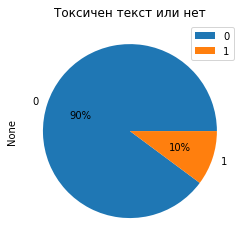

In [14]:
df.value_counts('toxic').plot(kind='pie', autopct='%1.0f%%', legend=True, title="Токсичен текст или нет")
plt.show()

На диаграмме виден дисбаланс классов, нетоксичных комментариев в 9 раза больше, чем токсичных.

## Обучение

### Модель решающего дерева

С помощью `GridSearchCV` будем изменять гиперпараметр модели решающего дерева `max_depth` от 20 до 30 с шагом 2. Также используем кросс-валидацию с параметром `cv=5`.

In [17]:
%%time
count_tf_idf = TfidfVectorizer(stop_words=stopwords)
dtc_model = DecisionTreeClassifier(random_state=12345, class_weight='balanced')

dtc_pipe = Pipeline([('count_tf_idf', count_tf_idf), 
                 ('dtc_model', dtc_model)])

dtc_parametrs = {'dtc_model__max_depth': range(20, 31, 2)}

dtc_grid = GridSearchCV(dtc_pipe, cv=5, param_grid=dtc_parametrs, scoring='f1')
dtc_grid.fit(features_train, target_train)

print(f'Средняя оценка F1 лучшей модели: {dtc_grid.best_score_:.3f}')
print("Глубина дерева:", dtc_grid.best_params_['dtc_model__max_depth'])

Средняя оценка F1 лучшей модели: 0.638
Глубина дерева: 30
CPU times: user 9min 55s, sys: 1.83 s, total: 9min 57s
Wall time: 9min 58s


### Модель случайного леса

С помощью `GridSearchCV` будем изменять гиперпараметры модели случайного леса `n_estimators` от 70 до 100 с шагом 10 и `max_depth` от 1 до 10 с шагом 2. Также используем кросс-валидацию с параметром `cv=5`.

In [19]:
%%time
rfc_model = RandomForestClassifier(random_state=12345, class_weight='balanced')

rfc_pipe = Pipeline([('count_tf_idf', count_tf_idf), 
                 ('rfc_model', rfc_model)])

rfc_parametrs = {'rfc_model__max_depth': range(1, 11, 2), 'rfc_model__n_estimators': range(70, 101, 10)}

rfc_grid = GridSearchCV(rfc_pipe, cv=5, param_grid=rfc_parametrs, scoring='f1')
rfc_grid.fit(features_train, target_train)

print(f'Средняя оценка F1 лучшей модели: {rfc_grid.best_score_:.3f}')
print("Глубина дерева:", rfc_grid.best_params_['rfc_model__max_depth'])
print("Количество деревьев:", rfc_grid.best_params_['rfc_model__n_estimators'])

Средняя оценка F1 лучшей модели: 0.355
Глубина дерева: 9
Количество деревьев: 100
CPU times: user 11min 21s, sys: 3.24 s, total: 11min 24s
Wall time: 11min 26s


### Модель логистической регрессии

С помощью `GridSearchCV` будем изменять гиперпараметр модели логистической регрессии `C` от 6 до 15 с шагом 2. Также используем кросс-валидацию с параметром `cv=5`.

In [23]:
%%time
lr_model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=12345)

lr_pipe = Pipeline([('count_tf_idf', count_tf_idf), 
                 ('lr_model', lr_model)])

lr_parametrs = {'lr_model__C': range(6, 16, 2)}

lr_grid = GridSearchCV(lr_pipe, cv=5, param_grid=lr_parametrs, scoring='f1')
lr_grid.fit(features_train, target_train)

print(f'Средняя оценка F1 лучшей модели: {lr_grid.best_score_:.3f}')
print("C:", lr_grid.best_params_['lr_model__C'])

Средняя оценка F1 лучшей модели: 0.763
C: 8
CPU times: user 16min 23s, sys: 27min 41s, total: 44min 5s
Wall time: 44min 7s


## Тестирование модели

Проверим лучшую модель - логистическую регрессию на тестовой выборке. Посчитаем `F1-меру` и `AUC-ROC` на тестовой выборке.

In [24]:
predictions = lr_grid.best_estimator_.predict(features_test)
print(f'F1-мера лучшей модели на тестовой выборке: {f1_score(target_test, predictions):.3f}')

F1-мера лучшей модели на тестовой выборке: 0.771


In [26]:
probabilities_test = lr_grid.best_estimator_.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

print(f'AUC-ROC лучшей модели на тестовой выборке: {roc_auc_score(target_test, probabilities_one_test):.3f}')

AUC-ROC лучшей модели на тестовой выборке: 0.970


На тестовой выборке `F1-мера` лучшей модели уменьшилась. Значение `AUC-ROC` больше `F1-меры`.

Построим ROC-кривую для лучшей модели и случайной модели на тестовой выборке.

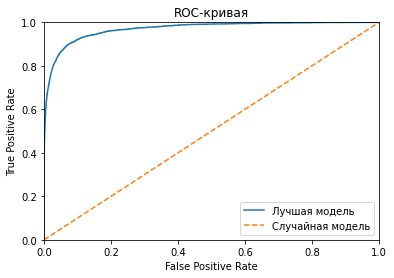

In [27]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

plt.figure()

plt.plot(fpr, tpr)

plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC-кривая')
plt.legend(['Лучшая модель','Случайная модель'])
plt.show()

Для модели, которая всегда отвечает случайно, ROC-кривая выглядит как прямая, идущая из левого нижнего угла в верхний правый. Чем график выше, тем больше значение TPR и лучше качество модели. Значение `AUC-ROC` и качество модели достаточно хорошее.

## Общий вывод

В результате исследования были выполнены следующие шаги: подготовка данных, обучение и тестирование моделей.

На этапе подготовки данные были загружены и изучены. В данных был лишний столбец, который был удален. Текстовые данные были очищены, т. е. были удалены лишние символы, остались только английские слова и пробелы. Затем текст был лемматизирован - форма слов была приведена к начальной. Также данные были поделены на выборки - обучающую и тестовую. Признаки создавались с помощью расчета TF-IDF, текст был перведен в векторы. В данных наблюдается сильный дисбаланс классов.

На этапе обучения и тестирования моделей были рассмотрены три модели: решающее дерево, случайный лес и логистическая регрессия. Для всех моделей для поиска лучших гиперпараметров использовался GridSearchCV, также при обучении и проверке моделей использовалась кросс-валидация. Наилучшие значения F1 у модели логистической регресии с гиперпараметрами max_iter=1000, class_weight='balanced', C=8.

Было проведено тестирование лучшей модели - логистической регресии, обученной на увеличенной выборке. Значение F1-меры на тестовой выборке - 0.771, AUC-ROC - 0.970, также был построен график ROC-кривой.